## Neural Networks
### Hand-in: Solve MNIST classification with basic sklearn functions

The goal of this exercise is to familiarise you with working with datasets and transferring the MLP classification from the PRACTICE to one of the standard benchmark datasets: MNIST or fashion MNIST.

Note: The original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains 28x28px images of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. *"If it doesn't work on **MNIST**, it won't work at all"*, they said. *"Well, if it does work on MNIST, it may still fail on others."*
A good alternative is using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) for the following reasons:
- MNIST is too easy. Convolutional nets can achieve 99.7% on MNIST (we will introduce this in the next lecture, thus, skip this for now). Classic machine learning algorithms can also achieve 97% easily.
- MNIST is overused.
- MNIST can not represent modern CV tasks.
Thus for your experiments, make your own choice after briefly looking into both.

For the hand-in, go through the following tasks and answer the following questions.

Tasks:
1. Search online about characteristics and usage of the MNIST and/or FashionMNIST data set
* **Dataset with 60,000 training and 10,000 test examples of images. It shows handwritten images with digits between 0 and 9.**

2. Build your own "data loader" to prepare training and test splits as well as input data and output labels. **See Code**

3. Reproduce the steps in the PRACTICE of using the MLP function from sklearn to classify the data. **See Code**

4. Understand and test what the respective loss function and optimisers are.
**optimiser:**
* **Stochastic Gradient descent was used first. Pro: It uses a subset of data and thus is computationally efficient. Con: It requires careful tuning of hyperparameters. (For a discussion see Question 3.)**

**loss function:**
* **cross-entropy loss function was used first. (For a discussion see Question 3.)**
5. Plot some training progress (e.g. plot the loss) **See Code**
6. Have a brief (!) experiment with different settings for the hyperparameters: batch_size, learning_rate, hidden_layer_sizes. **See Code**

Questions:
1. What is the best accuracy that you found?
* **The best accuracy was 0.9701**

2. What are good values of batch_size, learning_rate, hidden_layer_sizes?
* **The following hyperparameters were choosen based on trying:**
* **hidden layer sizes (60, 40):** In Model 2, the hidden layer sizes are increased which means the model has more neurons and more layers in the hidden part.
* **learning rate init (0.001):** Model 2 uses a smaller learning rate which generally results in slower convergence but can help the optimization process avoid overshooting the optimal weights. By allowing the learning rate to decrease more gradually, the model may find more accurate weights and achieve better performance.
* **epochs (number of training iteration) (100) in combination with early stopping (True):** Model 2 has more training epochs which allows the model to see the data more times during training, potentially leading to better convergence and improved performance. Due to the early stopping the iterations are stopped at epoch 47 as there was no improvement over the last 10 iterations. Thus, iterations of 50 should have been sufficient.
* **batch size (32):** Model 2 uses a larger batch size. This can offer advantages such as faster convergence and more stable gradients. The averaging of gradients over a larger batch can lead to more accurate weight updates, resulting in better performance.

3. What optimiser options did you choose (and why)?
* **Two optimisers were tested:**
* **Stochastic Gradient Descent as it a) can converge faster compared to other optimization algorithms, especially when dealing with large datasets and b) uses  Memory efficiently as it updates the model parameters based on individual samples or small batches of samples.**
* **Adam as it a) adjusts the learning rate individually for each parameter, which can help improve convergence and avoid getting stuck in suboptimal solutions and b) uses a momentum to accelerate convergence. Also, it is is known to be relatively robust to the choice of hyperparameters compared to other optimization algorithms.**
* **By trying both optimzers, it was found that SGD yields better results ceteris paribus.**

4. What max_iter do you need to converge?
* **48 were necessary in the end. It was decided to use 100 (a large number) and early stopping. Therebey, it is ensured that the number of epochs is suffiecient (avoid underfitting) but the training is stopped when no improvement results after 10 consecutive iterations (avoid overfitting).**

5. What did you observe in the results for good and bad hyperparameters?
* **For good hyperparameters, the learning curve shows that the training loss steadily decreases over time as the model learns (improving fit to training data), but not to fast (could be sign of overfitting). After reaching a certain point it should reach a plateau or slight fluctuation**
* **For bad hyperparameters,the learning curve fluctuated a lot.**
* **For bad hyperparameters, the confusion matrix showed large false classified labels for one number. Investigating furhter, it was discovered that the simple model always predicts this number (0).  This indicates that the model is to simple and does not capture the complexity present in the data well.**

In [19]:
from IPython.display import display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn import neural_network
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import UndefinedMetricWarning


#### Load MNIST data
You may consider just using np.loadtxt on https://python-course.eu/data/mnist/mnist_train.csv and https://python-course.eu/data/mnist/mnist_test.csv

In [2]:
# Task 2: Build your own "data loader" to prepare training and test splits as well as input data and output labels.

def data_loader(train_csv, test_csv):
    # Loading & preparing training data
    df_train = np.loadtxt(train_csv, delimiter=',')
    X_train = df_train[:, 1:]
    y_train = df_train[:, 0]
    
    # Loading & preparing test data
    df_test = np.loadtxt(test_csv, delimiter=',')
    X_test = df_test[:, 1:]
    y_test = df_test[:, 0]
    
    return df_train, df_test, X_train, y_train, X_test, y_test

In [3]:
# Load Data
df_train, df_test, X_train, y_train, X_test, y_test = data_loader("Data/mnist_train.csv", "Data/mnist_test.csv")

In [4]:
# Check loaded data: Look at shape
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 784)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


##### Consider some visualisations to get a feeling for the data set!

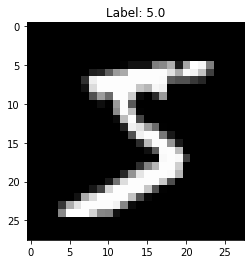

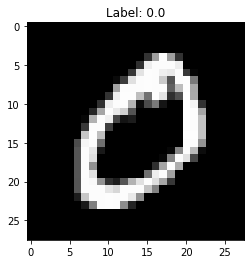

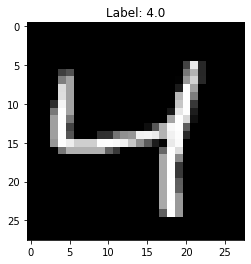

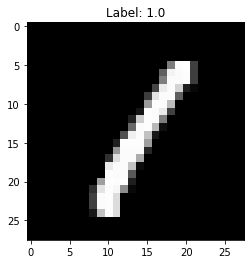

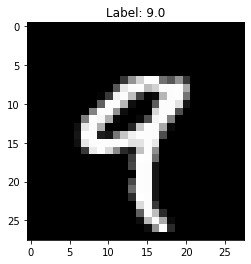

In [9]:
# Display few sample images (the first 5)
for i in range(5):
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.show()

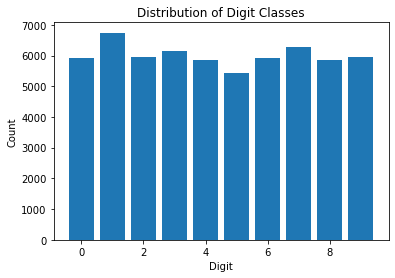

In [10]:
# Display the class distribution (distribution of numbers in the dataset)

# Convert y_train to integers
y_train = y_train.astype(int)

# Count the occurrences of each digit in the training set
digit_counts = np.bincount(y_train)

# Plot the bar chart
plt.bar(range(10), digit_counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digit Classes')
plt.show()

#### Build the model

In [11]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Task 3: Reproduce the steps in the PRACTICE of using the MLP function from sklearn to classify the data.
# parameters for the MLP shape
hidden_layer_sizes = (5, 4)  # tuple of sizes of hidden layers
activation ='relu'

#parameters for the learning
optimiser = 'sgd' 
learning_rate_init = 0.01  # learning_rate
learning_rate = 'constant'  # learning_rate_type
max_iter = 20  # epoches, number of training interations
batch_size = 1  # number of training examples per epoch
momentum = 0.95  # [0,1]

p_random_seed = 13
clf_mlp = neural_network.MLPClassifier(
    random_state=p_random_seed, solver=optimiser, activation=activation,
    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,
    max_iter=max_iter, learning_rate=learning_rate, momentum=momentum,
    batch_size=batch_size, nesterovs_momentum=True, alpha=1e-05,
    beta_1=0.9, beta_2=0.999, epsilon=1e-08, early_stopping=False,
    n_iter_no_change=10, power_t=0.5, tol=0.0001, validation_fraction=0.1,
    shuffle=True, verbose=1, warm_start=False)

In [22]:
# Fit data
clf_mlp.fit(X_train, y_train)

Iteration 1, loss = 2.34809449
Iteration 2, loss = 2.34698690
Iteration 3, loss = 2.34648452
Iteration 4, loss = 2.34706169
Iteration 5, loss = 2.34616736
Iteration 6, loss = 2.34679935
Iteration 7, loss = 2.34592387
Iteration 8, loss = 2.34694900
Iteration 9, loss = 2.34694760
Iteration 10, loss = 2.34633368
Iteration 11, loss = 2.34635400
Iteration 12, loss = 2.34667871
Iteration 13, loss = 2.34578563
Iteration 14, loss = 2.34485427
Iteration 15, loss = 2.34530051
Iteration 16, loss = 2.34669194
Iteration 17, loss = 2.34564985
Iteration 18, loss = 2.34495816
Iteration 19, loss = 2.34610269
Iteration 20, loss = 2.34542591


/Users/lindacaro/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=1e-05, batch_size=1, hidden_layer_sizes=(5, 4),
              learning_rate_init=0.01, max_iter=20, momentum=0.95,
              random_state=13, solver='sgd', verbose=1)

#### Show prediction and visualisation

In [14]:
# Show prediction Accuracy
test_accuracy = clf_mlp.score(X_test, y_test)
print("Prediction accuracy:", test_accuracy)

Prediction accuracy: 0.098


              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18       980
         1.0       0.00      0.00      0.00      1135
         2.0       0.00      0.00      0.00      1032
         3.0       0.00      0.00      0.00      1010
         4.0       0.00      0.00      0.00       982
         5.0       0.00      0.00      0.00       892
         6.0       0.00      0.00      0.00       958
         7.0       0.00      0.00      0.00      1028
         8.0       0.00      0.00      0.00       974
         9.0       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



Text(33.0, 0.5, 'true label')

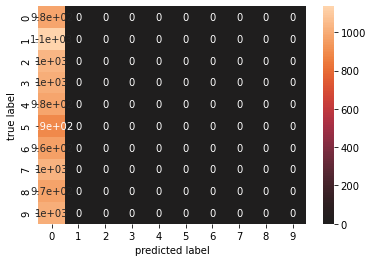

In [20]:
# Turnoff warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Analysing the training results
test_pred = clf_mlp.predict(X_test) # predict X_test
print(metrics.classification_report(y_test, test_pred)) # get metrics as results

confusion_matrix = metrics.confusion_matrix(y_test, test_pred) # create confusion matrix
plot_tree_cm = sns.heatmap(confusion_matrix, annot=True, center=0)
plot_tree_cm.set_xlabel('predicted label')
plot_tree_cm.set_ylabel('true label')

In [17]:
#plot the exact predictions
# print("Prediction:", list(zip(*[test_pred, y_test])))

proba = clf_mlp.predict_proba(X_test)
print("Prediction probabilities:", proba)

#plot the resulting weight matrix
print("Weights:", display([coef.shape for coef in clf_mlp.coefs_],  clf_mlp.coefs_))

Prediction probabilities: [[0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]
 [0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]
 [0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]
 ...
 [0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]
 [0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]
 [0.15130708 0.06880007 0.09557822 ... 0.07650084 0.10743327 0.11817534]]


[(784, 5), (5, 4), (4, 10)]

[array([[ 4.39356463e-03, -4.15239324e-03,  5.13045129e-03,
          7.36867641e-03,  7.47708143e-03],
        [-7.36485289e-04,  1.72517447e-03,  4.35913951e-03,
          2.24048247e-03,  3.51257823e-03],
        [-7.35624541e-03, -3.18875617e-03, -6.98482918e-03,
          5.64910591e-03, -2.01159235e-03],
        ...,
        [-1.57339293e-03,  7.79383997e-03, -4.28162012e-03,
         -8.45173219e-04,  5.04314002e-04],
        [-4.14873898e-03, -9.66325860e-04, -7.38922521e-03,
          1.80505023e-03,  1.55411165e-05],
        [ 2.48925138e-03, -4.53692411e-03,  3.84903638e-03,
         -9.01161207e-04, -2.41561626e-03]]),
 array([[-0.03169716, -0.00080303, -0.11627117, -0.08229726],
        [-0.0735262 , -0.04492923, -0.08018001, -0.08221915],
        [-0.10005232, -0.03634022, -0.17411666, -0.24029703],
        [-0.30086784, -0.02514715, -0.10807897, -0.38364148],
        [-0.1281347 , -0.04861212, -0.18274315, -0.24770832]]),
 array([[-5.21467908e-02, -1.43575448e-02,  2.998

Weights: None


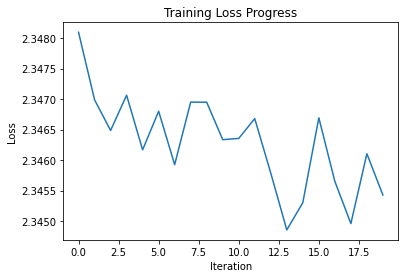

In [18]:
# Task 5: Plot some training progress (e.g. plot the loss)
plt.plot(clf_mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

#### Experimenting with Hyperparameters -> new model

In [23]:
# Task 6: Have a brief (!) experiment with different settings for the hyperparameters

# parameters for the MLP shape
hidden_layer_sizes = (60,40)  # tuple of sizes of hidden layers: increased size
activation ='relu'

#parameters for the learning
optimiser = 'sgd' 
learning_rate_init = 0.001  # learning rate: decreased
learning_rate = 'constant'  
max_iter = 100  # epoches, number of training interations: increased
batch_size = 32  # number of training examples per epoch: increased
momentum = 0.95 

p_random_seed = 13
clf_mlp2 = neural_network.MLPClassifier(
    random_state=p_random_seed, solver=optimiser, activation=activation,
    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,
    max_iter=max_iter, learning_rate=learning_rate, momentum=momentum,
    batch_size=batch_size, nesterovs_momentum=True, alpha=1e-05,
    beta_1=0.9, beta_2=0.999, epsilon=1e-08, early_stopping=True,
    n_iter_no_change=10, power_t=0.5, tol=0.0001, validation_fraction=0.1,
    shuffle=True, verbose=2, warm_start=False)

In [24]:
clf_mlp2.fit(X_train, y_train)

Iteration 1, loss = 0.44819158
Validation score: 0.933000
Iteration 2, loss = 0.17702582
Validation score: 0.947833
Iteration 3, loss = 0.13273011
Validation score: 0.956000
Iteration 4, loss = 0.10708999
Validation score: 0.957500
Iteration 5, loss = 0.08819117
Validation score: 0.960333
Iteration 6, loss = 0.07519287
Validation score: 0.960000
Iteration 7, loss = 0.06441907
Validation score: 0.961833
Iteration 8, loss = 0.05498752
Validation score: 0.962000
Iteration 9, loss = 0.04758213
Validation score: 0.963500
Iteration 10, loss = 0.04262063
Validation score: 0.963167
Iteration 11, loss = 0.03659779
Validation score: 0.965833
Iteration 12, loss = 0.03217590
Validation score: 0.966167
Iteration 13, loss = 0.02761797
Validation score: 0.963833
Iteration 14, loss = 0.02480369
Validation score: 0.966167
Iteration 15, loss = 0.02226632
Validation score: 0.965500
Iteration 16, loss = 0.01905765
Validation score: 0.967333
Iteration 17, loss = 0.01763450
Validation score: 0.965333
Iterat

MLPClassifier(alpha=1e-05, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(60, 40), max_iter=100, momentum=0.95,
              random_state=13, solver='sgd', verbose=2)

In [25]:
# Show prediction Accuracy
test_accuracy2 = clf_mlp2.score(X_test, y_test)
print("Prediction accuracy:", test_accuracy2)

Prediction accuracy: 0.9701


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       980
         1.0       0.98      0.99      0.99      1135
         2.0       0.96      0.96      0.96      1032
         3.0       0.97      0.97      0.97      1010
         4.0       0.97      0.97      0.97       982
         5.0       0.96      0.96      0.96       892
         6.0       0.97      0.97      0.97       958
         7.0       0.97      0.96      0.97      1028
         8.0       0.95      0.97      0.96       974
         9.0       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Text(33.0, 0.5, 'true label')

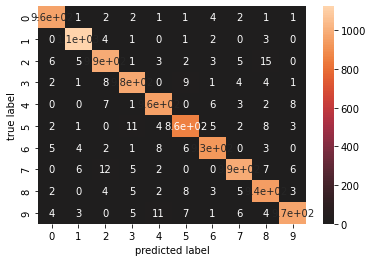

In [26]:
# Analysing the training results
test_pred2 = clf_mlp2.predict(X_test)
print(metrics.classification_report(y_test, test_pred2))

confusion_matrix2 = metrics.confusion_matrix(y_test, test_pred2)
plot_tree_cm2 = sns.heatmap(confusion_matrix2, annot=True, center=0)
plot_tree_cm2.set_xlabel('predicted label')
plot_tree_cm2.set_ylabel('true label')

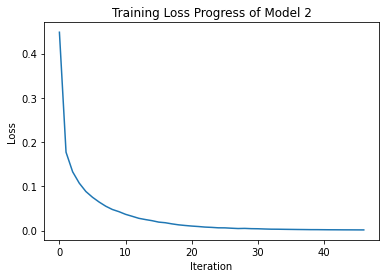

In [27]:
# Plotting the loss curve on training data
plt.plot(clf_mlp2.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Progress of Model 2')
plt.show()